In [1]:
suppressMessages(library(repr))
options(repr.plot.width=25,
        repr.plot.height=10,
        #repr.plot.pointsize=50,
        repr.plot.family='serif'
       )

In [2]:
source("../src/filter_sites.R")
source("../src/funciones.R")

suppressMessages(library(tidyverse))
suppressMessages(library(lubridate))

In [3]:
suppressMessages(library(saqgetr))
suppressMessages(library(tidyverse))
suppressMessages(library(lubridate))
suppressMessages(library(worldmet))

# En lugar de cargar el paquete openair se utiliza el ggopenair,
# otro paquete desarrollado por el mismo que Openair con el objetivo de 
# utilizar ggplot2 en lugar de lattice para la representaciones graficas
#
#suppressMessages(library(openair))
suppressMessages(library(ggopenair)) 


suppressMessages(library(gridExtra))
suppressMessages(library(mblm))

In [4]:
nn.sites <- read.csv("../data/csv/nn_sites.csv")

df <- data.frame()
percent <- c(0.5, 0.7, 0.8, 0.9)

for (nm in names(nn.sites)[6:length(names(nn.sites))]) {
    for (i in 1:length(percent)) {
        count <- sum(nn.sites[, nm] >= percent[i])
        df[i, nm] <- count
    } 
}

row.names(df) <- percent
head(df)

,countMto,ws,wd,air_temp,atmos_pres,visibility,dew_point,RH,ceil_hgt,cl_1,cl_2,cl_3,cl,cl_1_height,cl_2_height,cl_3_height,precip_12,precip,precip_6,pwc
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
0.5,159,159,159,159,46,66,159,159,26,44,0,0,44,43,0,0,0,14,0,1
0.7,159,159,142,159,38,33,146,146,3,7,0,0,7,7,0,0,0,14,0,1
0.8,159,152,111,159,38,33,135,135,3,0,0,0,0,0,0,0,0,8,0,1
0.9,159,142,60,151,38,33,133,133,0,0,0,0,0,0,0,0,0,2,0,1


In [5]:
sites <- relevant.sites(sites.fl="../data/csv/nn_sites.csv",
                        cols=1:12,
                        minValue=0.0,
                        percent=0.7,
                        numVar=7,
                        unique.cty=TRUE
                       )
head(sites)

,Municipio,siteAQ,countAQ,siteMto,dist,countMto,ws,wd,air_temp,atmos_pres,visibility,dew_point,numVar
,<chr>,<chr>,<int>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
52,Oviedo,es1268a,419493,080150-99999,0.924192,62959,0.9981099,0.9821630,0.9999841,0.9994758,0.9886434,0.9941708,7
26,Ourense,es1096a,405864,080440-99999,61.344307,55321,0.9926429,0.9699752,0.9999819,0.9934564,0.9898411,0.9961859,7
134,Valladolid,es1632a,394858,081410-99999,1.411223,63416,0.9810458,0.9746752,0.9999685,0.9997162,0.9941813,0.9973193,7
29,Vigo,es1137a,396299,080440-99999,25.923040,55321,0.9926429,0.9699752,0.9999819,0.9934564,0.9898411,0.9961859,7
63,Gijón,es1271a,420559,080140-99999,3.136950,16220,0.9996917,0.8863132,0.9999383,0.9996301,0.9996301,0.9996917,7
115,Las Palmas de Gran Canaria,es1573a,355339,600200-99999,87.398704,42552,0.9992715,0.9896127,0.9999060,0.9992480,0.9854766,0.9996945,7


## Abrir los datos de las estacions

In [6]:
read.dataAQ <- function(site) {
    read.csv(paste("../data/csv/dataAQ/",
                   site,".csv",sep=""))
}

read.dataMto <- function(site) {
    read.csv(paste("../data/csv/dataMto/", 
                   site, ".csv", sep=""))
}

In [7]:
numSites = 2

data.all <- data.frame()
#data.all <- vector(mode="list", length=numSites)

for (row in 1:numSites) {
    data.AQ <- read.dataAQ(sites$siteAQ[row])
    data.AQ <- pivot.by.pollut(data.AQ, 
                               levels(as.factor(data.AQ$variable)),
                               by="week",
                               FUN="mean"
                              )
    
    data.AQ <- data.AQ %>% 
                group_by(date)%>%
                summarise(no = mean(no),
                          no2 = mean(no2),
                          o3= mean(o3),
                          pm10= mean(pm10),
                         )
    
    data.Mto <- read.dataMto(sites$siteMto[row])
    data.Mto$date <- round_date(ymd_hms(data.Mto$date), unit="week")
    
    data.Mto <- data.Mto %>% 
                    group_by(date)%>%
                    summarise(
                              ws = mean(ws),
                              wd = mean(wd),
                              air_temp = mean(air_temp),
                              atmos_pres = mean(atmos_pres),
                              visibility = mean(visibility),
                              dew_point = mean(dew_point),
                              RH = mean(RH),
                             )
    
    merged.data <- merge(x=data.AQ, 
                         y=data.Mto, 
                         by="date",all.x=TRUE, all.y=TRUE)
    
    data.all <- rbind(data.all,
                      cbind(data.frame(site=rep(sites$siteAQ[row], 
                                                nrow(merged.data))), 
                            merged.data
                           )
                     )
}

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



In [8]:
sum(is.na(data.all))
sum(!is.na(data.all))

[1] 1563

[1] 13387

```R
while(sum(is.na(data.all)) != 0) {
    for (col in 3:ncol(data.all)) {
        for (i in which(is.na(data.all[, col]))) {
            data.all[i, col] <- mean(data.all[i-2:i+2, col], na.rm=TRUE)
        }
    }
    print("1")
}

sum(is.na(data.all))
sum(!is.na(data.all))

```

In [9]:
head(data.all)

,site,date,no,no2,o3,pm10,ws,wd,air_temp,atmos_pres,visibility,dew_point,RH
,<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,es1268a,2010-01-03,22.81694,38.02835,28.26670,33.35035,1.972727,201.8182,6.956818,1009.011,10625.000,3.5931818,80.47945
2,es1268a,2010-01-10,23.28357,42.36547,33.07274,50.82289,2.062500,NA,2.116071,1012.421,9773.214,-0.5196429,84.53579
3,es1268a,2010-01-17,50.06107,53.84981,22.74211,32.76239,1.903636,NA,9.914545,1013.975,10700.000,6.1545455,79.58717
4,es1268a,2010-01-24,28.81239,45.95810,26.61419,30.44052,1.574545,NA,7.923636,1023.155,10183.636,4.9254545,82.34107
5,es1268a,2010-01-31,31.10499,45.30308,34.50354,23.94381,2.212500,NA,5.230357,1017.623,11678.571,2.9482143,86.02101
6,es1268a,2010-02-07,24.16643,36.79909,36.86845,28.78913,2.725000,NA,8.867857,1010.541,12260.714,6.5178571,85.93649


In [10]:
cor(scale(data.all[data.all$site == "es1096a", 3:13]), 
    method = "pearson",  #("pearson", "kendall", "spearman")
    #na.rm = TRUE,
    use="na.or.complete" #("everything", "all.obs", "complete.obs", "na.or.complete", "pairwise.complete.obs")
   )

,no,no2,o3,pm10,ws,wd,air_temp,atmos_pres,visibility,dew_point,RH
no,1.00000000,0.6790674,-0.78892075,0.5073216,-0.31029489,-0.62470589,-0.59488690,0.13912940,-0.06237726,-0.55222986,0.1498263
no2,0.67906739,1.0000000,-0.50155315,0.3010672,-0.15716677,-0.46940078,-0.51039273,-0.16052659,-0.27281610,-0.45741546,0.1769887
o3,-0.78892075,-0.5015531,1.00000000,-0.4349463,0.36858540,0.64555991,0.48667101,-0.07205237,0.06109203,0.28978808,-0.4222532
pm10,0.50732156,0.3010672,-0.43494632,1.0000000,-0.14901911,-0.50851129,-0.28470097,0.27881072,0.22865811,-0.37348070,-0.1227950
ws,-0.31029489,-0.1571668,0.36858540,-0.1490191,1.00000000,0.44760951,0.06481969,-0.05040299,0.02921042,-0.10682455,-0.3085154
wd,-0.62470589,-0.4694008,0.64555991,-0.5085113,0.44760951,1.00000000,0.46288467,0.10667765,-0.02187989,0.40982866,-0.1754607
air_temp,-0.59488690,-0.5103927,0.48667101,-0.2847010,0.06481969,0.46288467,1.00000000,0.03460597,0.30901418,0.86712957,-0.4030747
atmos_pres,0.13912940,-0.1605266,-0.07205237,0.2788107,-0.05040299,0.10667765,0.03460597,1.00000000,0.36789599,-0.15807699,-0.3977473
visibility,-0.06237726,-0.2728161,0.06109203,0.2286581,0.02921042,-0.02187989,0.30901418,0.36789599,1.00000000,0.02662664,-0.5869598
dew_point,-0.55222986,-0.4574155,0.28978808,-0.3734807,-0.10682455,0.40982866,0.86712957,-0.15807699,0.02662664,1.00000000,0.1028972


Warning message:
“Removed 1 rows containing missing values (geom_point).”


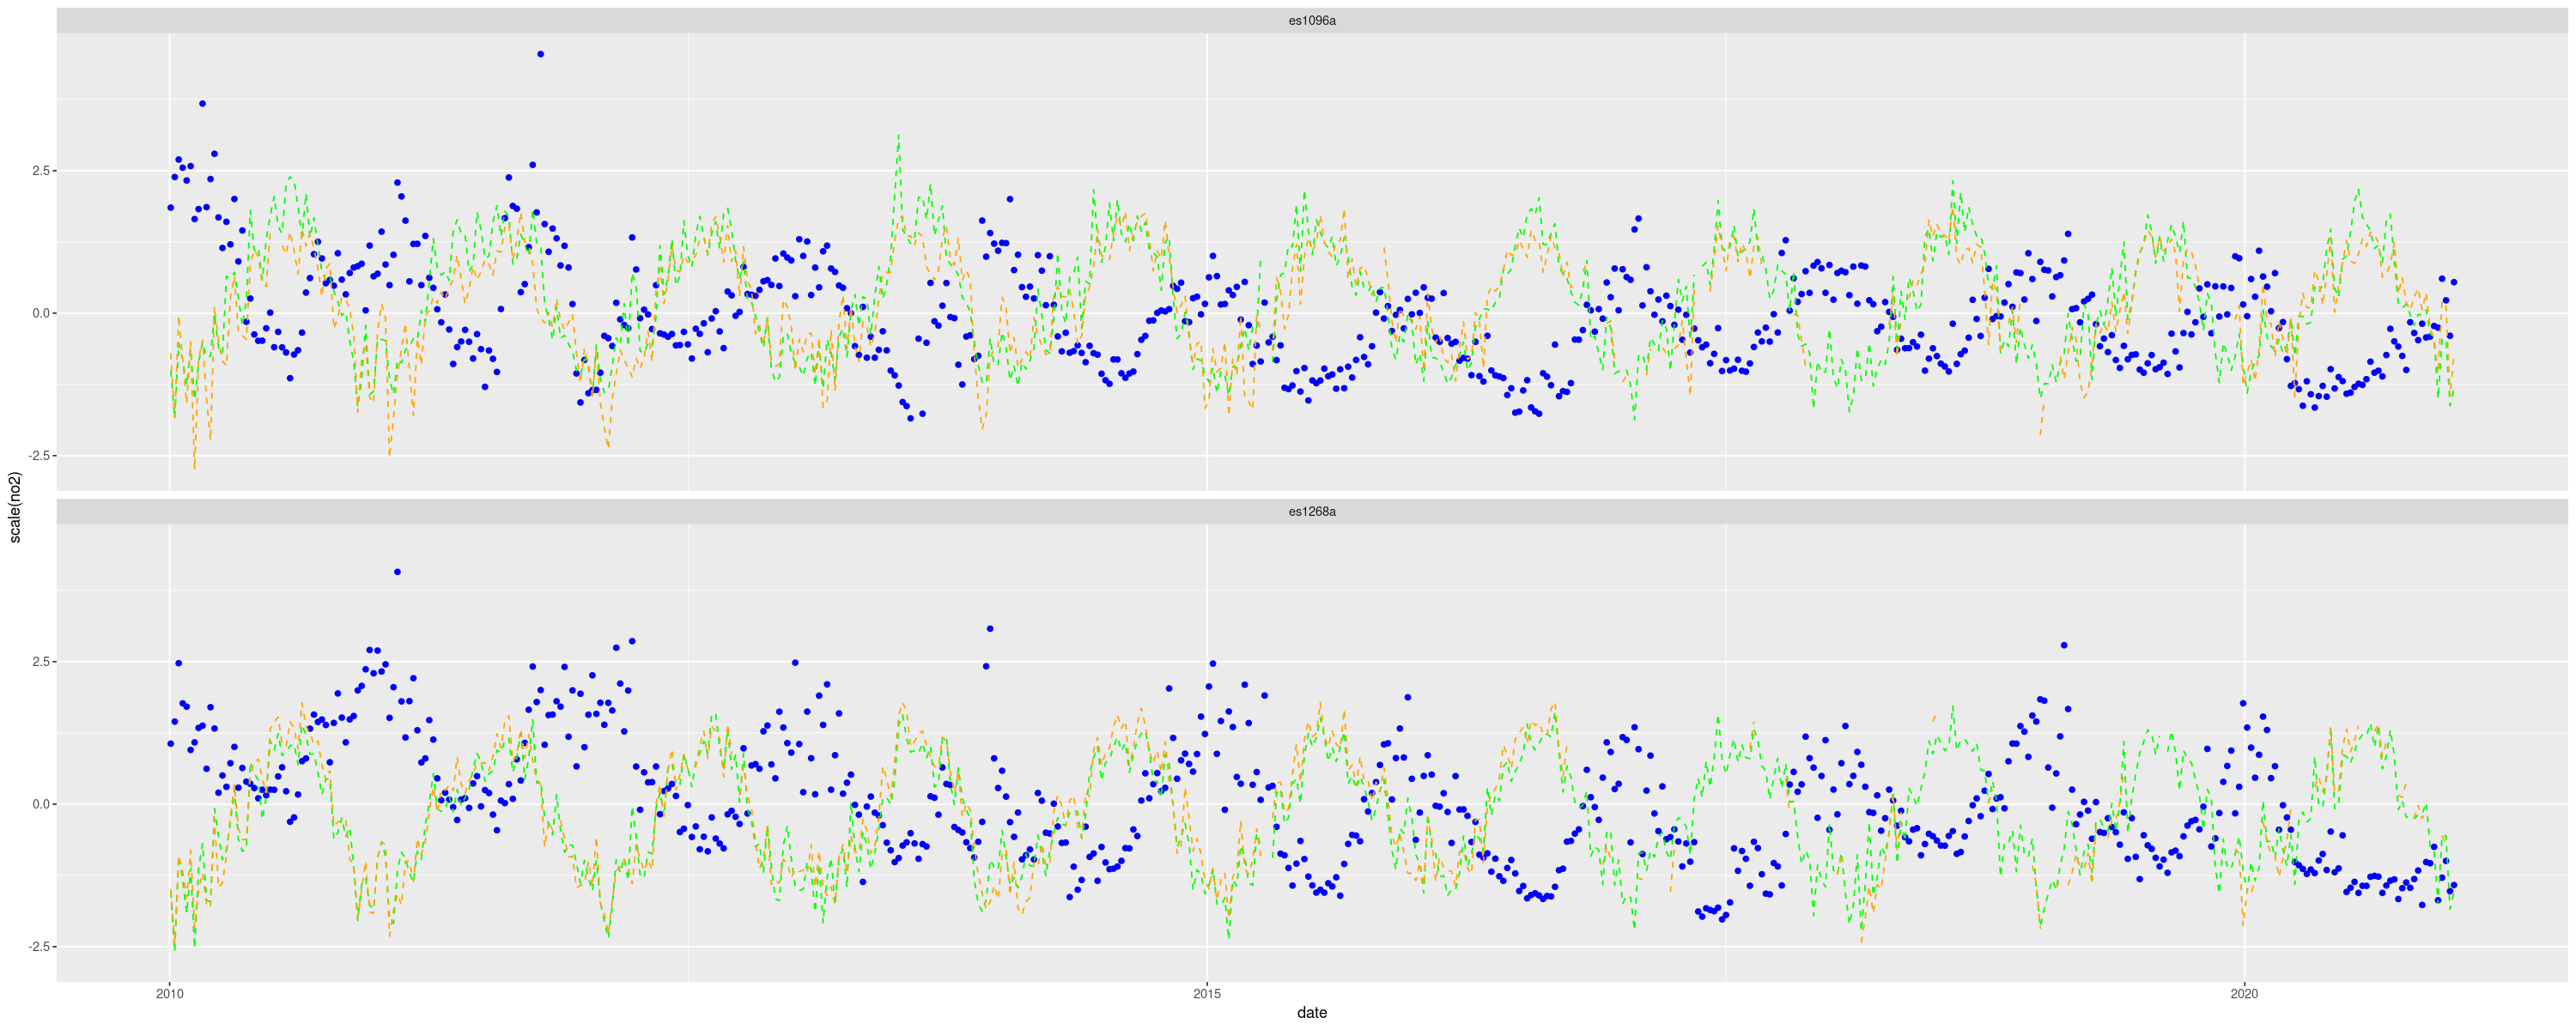

In [11]:
ggplot(data = data.all, aes(x = date), group = names(data.all)) +
    geom_point(aes(y = scale(no2)),       color = "blue")  + 
    geom_line( aes(y = scale(air_temp)),  color="green",     linetype = "dashed") + 
    #geom_line( aes(y = scale(ws)),        color="purple",    linetype = "dashed") + 
    #geom_line( aes(y = scale(wd)),        color="lightblue", linetype = "dashed") + 
    geom_line( aes(y = scale(dew_point)), color="orange",    linetype = "dashed") + 
    facet_wrap(~site, ncol=1)

In [12]:
# 12 mth/yr
# 52.1429 wk/yr
# 366 dy/yt
# 8784 hr/yr
fit <- lm(no2 ~ (sin(2*pi/(8784/3)*(air_temp))+cos(2*pi/(8784/3)*(air_temp))
                 #+ sin(2*pi/(8784/3)*(ws))+cos(2*pi/(8784/3)*(ws))
                 #+ sin(2*pi/(8784/3)*(dew_point))+cos(2*pi/(8784/3)*(dew_point))
                 #+ sin(2*pi/(8784/3)*(wd))+cos(2*pi/(8784/3)*(wd))
                 ),
          data.all[data.all$site == "es1268a" &
                   data.all$date <= "2020-03-14", ])

In [13]:
y.pre <- predict(fit, newdata=data.all[data.all$site == "es1268a" &
                                   data.all$date <= "2020-03-14", ])

y.drnt <- predict(fit, newdata=data.all[data.all$site == "es1268a" &
                                   data.all$date >= "2020-03-14", ])

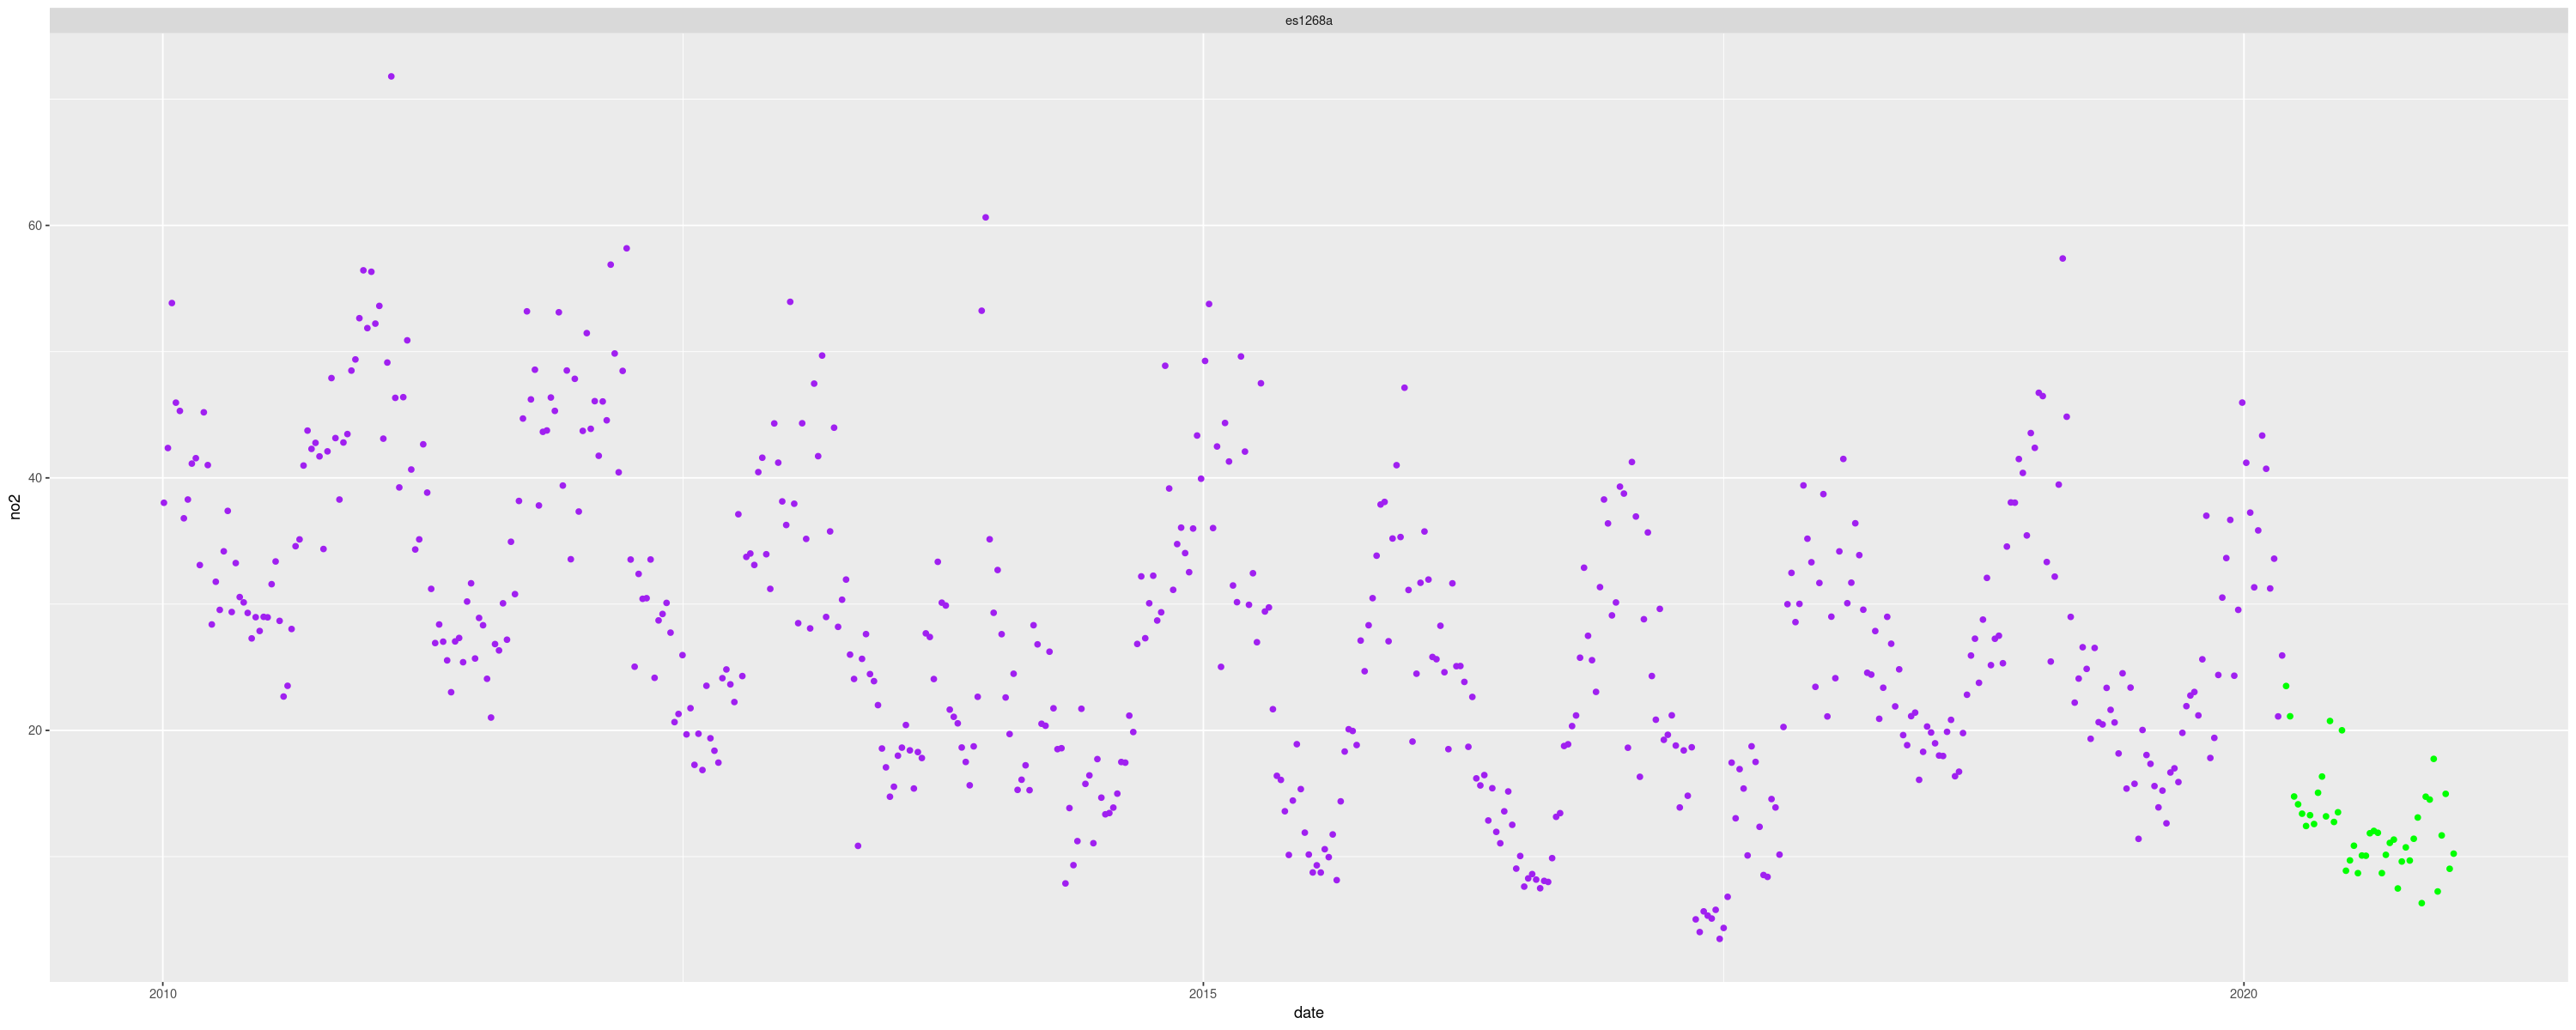

In [14]:
preCOVID <- ggplot() + 
            geom_point(data=data.all[data.all$site == "es1268a" &
                                     data.all$date <= ymd("2020-03-14"), ], aes(x=date, y=no2), color="purple") +
            #geom_line(aes(x=data.all[data.all$site == "es1268a" &
            #                         data.all$date <= ymd("2020-03-14"), ]$date, 
            #              y=fit$fitted.values), color="blue") +
            #facet_wrap(~site, ncol=1)

#COVID <- ggplot() + 
            geom_point(data=data.all[data.all$site == "es1268a" &
                                     data.all$date >= ymd("2020-03-14"), ], aes(x=date, y=no2), color="green") +
            #geom_line(aes(x=data.all[data.all$site == "es1268a" &
            #                         data.all$date >= ymd("2020-03-14"), ]$date, 
            #              y=y.drnt), color="darkgreen") + 
            facet_wrap(~site, ncol=1)
    
#grid.arrange(preCOVID, COVID, nrow = 1)
preCOVID